## Prep/loading data

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [53]:
%store -r bivariate_regressions
%store -r bivariate_regressions_accounts
%store -r single_regressions
%store -r single_regressions_accounts
%store -r multiple_regressions
%store -r multiple_regressions_accounts

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [54]:
bivariate_regressions[0].keys()

dict_keys(['model', 'name', 'data', 'dependent_variable', 'independent_variables', 'goodness_of_fit'])

In [55]:
foundational_df_no_transformations = pd.read_csv('output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('output/foundational_transformed_accounts.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [56]:
# as a data frame
scaler_df = pd.read_csv('output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('output/scaler_values_accounts.csv')

In [57]:
# original scaler object used to scale the values
%store -r scaler

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [58]:
all_regressions = bivariate_regressions + single_regressions + multiple_regressions
df_regressions = pd.DataFrame(all_regressions)

In [59]:
all_regressions_accounts = bivariate_regressions_accounts + single_regressions_accounts + multiple_regressions_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
# goodness_of_fit_df_accounts = pd.json_normalize(df_regressions_accounts['goodness_of_fit'])
# goodness_of_fit_df_accounts.head(15)

Which bivariate regressions have the best $R^2$?

In [60]:
bivariate_regressions_df = df_regressions[df_regressions['name'].str.contains('Bivariate')]
bivariate_regressions_df = bivariate_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_overview = bivariate_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_overview = pd.concat([bivariate_regressions_df_overview.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview = pd.concat([bivariate_regressions_df_overview.drop(['coefs'], axis=1), bivariate_regressions_df_overview['coefs'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview = bivariate_regressions_df_overview.loc[:,~bivariate_regressions_df_overview.columns.str.contains('T.True')]
bivariate_regressions_df_overview = bivariate_regressions_df_overview.drop(['model_name'], axis=1)
bivariate_regressions_df_overview

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,Intercept,Group Var
15,Pooled OLS Bivariate linearmodels,socialsupport,[energy],0.379540,-102.755131,NaN,-0.050686,-0.630133,NaN,NaN
19,Random Effects Bivariate linearmodels,socialsupport,[energy],0.379402,-65.410081,NaN,-0.040853,-0.635149,NaN,NaN
14,Pooled OLS Bivariate,socialsupport,[energy],0.343393,-86.762939,177.525879,-0.001666,-0.590920,NaN,NaN
8,Pooled OLS Bivariate linearmodels,education,[energy],0.310808,-119.200711,NaN,-0.046673,-0.648380,NaN,NaN
7,Pooled OLS Bivariate,education,[energy],0.289333,-101.992381,207.984762,-0.026072,-0.634377,NaN,NaN
12,Random Effects Bivariate linearmodels,education,[energy],0.279613,-56.529715,NaN,-0.040034,-0.450138,NaN,NaN
18,Random Effects Bivariate,socialsupport,[energy],0.225885,-57.549702,119.099405,-0.000907,-0.588194,NaN,NaN
1,Pooled OLS Bivariate linearmodels,hale,[energy],0.211513,-121.003231,NaN,-0.077018,-0.517586,NaN,NaN
0,Pooled OLS Bivariate,hale,[energy],0.182640,-104.979611,213.959222,-0.079699,-0.494170,NaN,NaN
5,Random Effects Bivariate linearmodels,hale,[energy],0.159684,-16.388631,NaN,-0.090497,-0.273963,NaN,NaN


Don't trust the fixed effects result, it seems to have the best r squared but it's likely biased (maybe was wrongly calculated).
I think the Pooled OLS model has a better R squared because a model with only energy does not (cannot?) predict historical variation well? Then a simple pooled OLS will show a better fit

Going with **Mixed effects** estimate for now as it seems to be the most plausible

In [61]:
selected_bivariate_model_hale = bivariate_regressions_df.iloc[18]['model']
selected_bivariate_model_education = bivariate_regressions_df.iloc[19]['model']
selected_bivariate_model_socialsupport = bivariate_regressions_df.iloc[20]['model']
selected_bivariate_model_hale.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: hale    
No. Observations: 79      Method:             REML    
No. Groups:       31      Scale:              0.0830  
Min. group size:  1       Log-Likelihood:     -64.0364
Max. group size:  3       Converged:          Yes     
Mean group size:  2.5                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
const       -0.105    0.163 -0.644 0.519 -0.425  0.215
energy      -0.286    0.160 -1.787 0.074 -0.600  0.028
Group Var    0.790    0.997                           
======================================================

"""

In [62]:
bivariate_regressions_df_accounts = df_regressions_accounts[df_regressions_accounts['name'].str.contains('Bivariate')]
bivariate_regressions_df_accounts = bivariate_regressions_df_accounts.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_accounts_overview = bivariate_regressions_df_accounts[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_accounts_overview = pd.concat([bivariate_regressions_df_accounts_overview.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_accounts_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
# bivariate_regressions_df_accounts_overview.head(15)

In [63]:
selected_bivariate_model_hale_accounts = bivariate_regressions_df_accounts.iloc[0]['model']

Which single regressions have the best $R^2$?

In [64]:
single_regressions_df = df_regressions[df_regressions['name'].str.contains('Single')]
single_regressions_df = single_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_overview = single_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_overview = pd.concat([single_regressions_df_overview.drop(['goodness_of_fit'], axis=1), single_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_overview = pd.concat([single_regressions_df_overview.drop(['coefs'], axis=1), single_regressions_df_overview['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_overview = single_regressions_df_overview.loc[:,~single_regressions_df_overview.columns.str.contains('T.True')]
single_regressions_df_overview = single_regressions_df_overview.drop(['model_name'], axis=1)
single_regressions_df_overview.head(20)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,providential,energy:providential,overlooked,energy:overlooked,other,energy:other,Intercept,Group Var
28,Pooled OLS Single,hale,"[energy, material]",0.675495,-67.450807,142.901615,-0.110172,-0.278917,0.726419,-0.377938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Pooled OLS Single linearmodels,hale,"[energy, material]",0.570348,-91.423087,NaN,-0.117054,-0.335337,0.568980,-0.223094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,Pooled OLS Single,education,"[energy, providential]",0.489618,-87.876632,183.753264,0.038054,-0.609349,NaN,NaN,-0.423025,-0.119693,NaN,NaN,NaN,NaN,NaN,NaN
78,Pooled OLS Single linearmodels,socialsupport,"[energy, overlooked]",0.480376,-93.374941,NaN,-0.018407,-0.558223,NaN,NaN,NaN,NaN,0.406027,-0.178352,NaN,NaN,NaN,NaN
82,Random Effects Single linearmodels,socialsupport,"[energy, overlooked]",0.480333,-59.732154,NaN,-0.015736,-0.564252,NaN,NaN,NaN,NaN,0.405135,-0.178527,NaN,NaN,NaN,NaN
64,Pooled OLS Single linearmodels,education,"[energy, providential]",0.473066,-105.539347,NaN,0.008189,-0.605676,NaN,NaN,-0.401273,-0.095159,NaN,NaN,NaN,NaN,NaN,NaN
33,Random Effects Single linearmodels,hale,"[energy, material]",0.461172,-14.751961,NaN,-0.102936,-0.243335,0.349542,-0.069568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Random Effects Single linearmodels,education,"[energy, providential]",0.452491,-47.150676,NaN,0.011970,-0.460507,NaN,NaN,-0.474358,-0.095299,NaN,NaN,NaN,NaN,NaN,NaN
85,Pooled OLS Single linearmodels,socialsupport,"[energy, material]",0.452272,-95.850607,NaN,-0.074485,-0.505667,0.192102,-0.186891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,Pooled OLS Single linearmodels,education,"[energy, material]",0.449904,-107.561153,NaN,-0.066608,-0.571163,0.405843,-0.065563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pick some interesting models from the table

In [65]:
selected_single_model_hale_material = single_regressions_df.iloc[6]['model']
selected_single_model_education_providential = single_regressions_df.iloc[7]['model']
selected_single_model_socialsupport_other = single_regressions_df.iloc[20]['model']
# Mixed effects models
# selected_single_model_hale_material = single_regressions_df.iloc[73]['model']
# selected_single_model_education_material = single_regressions_df.iloc[77]['model']
# selected_single_model_education_providential = single_regressions_df.iloc[78]['model']

In [66]:
single_regressions_df_accounts = df_regressions_accounts[df_regressions_accounts['name'].str.contains('Single')]
single_regressions_df_accounts = single_regressions_df_accounts.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_accounts_overview = single_regressions_df_accounts[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_accounts_overview = pd.concat([single_regressions_df_accounts_overview.drop(['goodness_of_fit'], axis=1), single_regressions_df_accounts_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview = pd.concat([single_regressions_df_accounts_overview.drop(['coefs'], axis=1), single_regressions_df_accounts_overview['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview = single_regressions_df_accounts_overview.loc[:,~single_regressions_df_accounts_overview.columns.str.contains('T.True')]
single_regressions_df_accounts_overview = single_regressions_df_accounts_overview.drop(['model_name'], axis=1)
single_regressions_df_accounts_overview

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,other,energy:other,providential,energy:providential,overlooked,energy:overlooked,Intercept,Group Var
84,Pooled OLS Single Accounts,socialsupport,"[energy, material]",0.376824,-353.724318,715.448635,0.075703,-0.585048,0.268842,-0.174455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Pooled OLS Single Accounts,hale,"[energy, other]",0.373181,-340.665976,689.331951,-0.007333,-0.549222,NaN,NaN,-0.241839,0.302994,NaN,NaN,NaN,NaN,NaN,NaN
85,Pooled OLS Single linearmodels Accounts,socialsupport,"[energy, material]",0.365685,-411.736443,NaN,0.037450,-0.577791,0.279001,-0.193814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Pooled OLS Single linearmodels Accounts,hale,"[energy, other]",0.357427,-391.607915,NaN,0.031240,-0.553385,NaN,NaN,-0.225127,0.319854,NaN,NaN,NaN,NaN,NaN,NaN
63,Pooled OLS Single Accounts,education,"[energy, providential]",0.353635,-357.399089,722.798178,-0.004493,-0.600691,NaN,NaN,NaN,NaN,-0.214017,-0.464086,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Mixed Effects Single Accounts,education,"[energy, other]",NaN,-231.476422,NaN,0.029634,0.979647,NaN,NaN,0.209074,0.327621,NaN,NaN,NaN,NaN,NaN,18.169987
83,Mixed Effects Single Accounts,socialsupport,"[energy, overlooked]",NaN,-262.339896,NaN,-0.010153,-0.729930,NaN,NaN,NaN,NaN,NaN,NaN,0.090375,-0.046918,NaN,2.149080
90,Mixed Effects Single Accounts,socialsupport,"[energy, material]",NaN,-261.418090,NaN,0.015525,-0.711715,0.173525,-0.065665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.909492
97,Mixed Effects Single Accounts,socialsupport,"[energy, providential]",NaN,-263.239489,NaN,-0.014452,-0.727068,NaN,NaN,NaN,NaN,-0.038272,0.004053,NaN,NaN,NaN,2.201220


Choose the best-looking model (mostly looking at r-squared, but also that coefficients are significant/have correct signs)

In [67]:
selected_single_model_overlooked_hale_accounts = single_regressions_df_accounts.iloc[1]['model']

Which multiple regressions have the best $R^2$?

In [84]:
# multiple_regressions_df_accounts = df_regressions_accounts[df_regressions_accounts['name'].str.contains('Multiple')]
# multiple_regressions_df_accounts = multiple_regressions_df_accounts.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
# multiple_regressions_df_accounts_overview = multiple_regressions_df_accounts[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
# multiple_regressions_df_accounts_overview = pd.concat([multiple_regressions_df_accounts_overview.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_accounts_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
# multiple_regressions_df_accounts_overview = multiple_regressions_df_accounts_overview.drop(['model_name'], axis=1)
# multiple_regressions_df_accounts_overview.head(30)
# Optionally same for labour cost survey data
multiple_regressions_df = df_regressions[df_regressions['name'].str.contains('Multiple')]
multiple_regressions_df = multiple_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
multiple_regressions_df_overview = multiple_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
multiple_regressions_df_overview = pd.concat([multiple_regressions_df_overview.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
multiple_regressions_df_overview = multiple_regressions_df_overview.drop(['model_name'], axis=1)
multiple_regressions_df_overview.head(15)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,coefs
119,Pooled OLS Multiple,hale,"[energy, material, goveffectiveness]",0.544560,-80.839877,169.679755,const -0.067885 energy ...
126,Pooled OLS Multiple,hale,"[energy, material, gini]",0.540669,-81.175832,170.351664,const -0.079007 energy -0.446661 mate...
189,Pooled OLS Multiple,education,"[energy, providential, goveffectiveness]",0.538993,-83.857615,175.715230,const 0.075317 energy ...
127,Pooled OLS Multiple linearmodels,hale,"[energy, material, gini]",0.533441,-82.559401,NaN,const -0.069944 energy -0.441136 mate...
120,Pooled OLS Multiple linearmodels,hale,"[energy, material, goveffectiveness]",0.532103,-95.430998,NaN,const -0.088396 energy ...
190,Pooled OLS Multiple linearmodels,education,"[energy, providential, goveffectiveness]",0.522486,-100.910742,NaN,const 0.015811 energy ...
196,Pooled OLS Multiple,education,"[energy, providential, gini]",0.521401,-85.336910,178.673820,const 0.044625 energy -0.468...
218,Pooled OLS Multiple linearmodels,socialsupport,"[energy, overlooked, goveffectiveness]",0.501793,-91.396742,NaN,const 0.043279 energy ...
197,Pooled OLS Multiple linearmodels,education,"[energy, providential, gini]",0.500948,-89.133929,NaN,const 0.019251 energy -0.480...
222,Random Effects Multiple linearmodels,socialsupport,"[energy, overlooked, goveffectiveness]",0.497119,-63.270842,NaN,const 0.049989 energy ...


In [89]:
selected_multiple_model_hale_material_goveffectiveness = multiple_regressions_df.iloc[12]['model']
selected_multiple_model_education_providential_goveffectiveness = multiple_regressions_df.iloc[10]['model']
selected_multiple_model_education_providential_goveffectiveness.summary

Dep. Variable:,education,R-squared:,0.2949
Estimator:,RandomEffects,R-squared (Between):,0.5491
No. Observations:,94,R-squared (Within):,0.0868
Date:,"Sun, Feb 11 2024",R-squared (Overall):,0.5162
Time:,11:19:27,Log-likelihood,-46.807
Cov. Estimator:,Clustered,,
,,F-statistic:,12.545
Entities:,33,P-value,0.0000
Avg Obs:,2.8485,Distribution:,"F(3,90)"
Min Obs:,1.0000,,
Max Obs:,3.0000,F-statistic (robust):,44.892


Accounts data -- I will likely use this data in the thesis. Used labour costs for demonstration purposes for now as it has less data points (charts should be more readable), the results are generally fairly similar between the two data sets.

Some rules for model selection:
1. Will not use Pooled OLS even if it has a better R-squared (which it does in some cases), since it's not a good fit for our data. Kind of confirmed this formally with an F-test, need to finalise.
2. The first "Fixed Effects Multiple" r-squared estimates are likely exaggerated/biased, will need to revisit

Check coefficients for some selected models

In [76]:
selected_bivariate_model_hale.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: hale    
No. Observations: 79      Method:             REML    
No. Groups:       31      Scale:              0.0830  
Min. group size:  1       Log-Likelihood:     -64.0364
Max. group size:  3       Converged:          Yes     
Mean group size:  2.5                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
const       -0.105    0.163 -0.644 0.519 -0.425  0.215
energy      -0.286    0.160 -1.787 0.074 -0.600  0.028
Group Var    0.790    0.997                           
======================================================

"""

In [82]:
selected_single_model_overlooked_hale_accounts.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hale   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     59.94
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           2.89e-30
Time:                        12:08:37   Log-Likelihood:                -340.67
No. Observations:                 298   AIC:                             689.3
Df Residuals:                     294   BIC:                             704.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0073      0.044     -0.165      0.869      -0.095       0.080
energy          -0.5492      0.048    -11.336      0.000      -0.645      -0.454
other           -0.2418      0.049     -4.923      0.000      -0.339      -0.145
energy:other     0.3030      0.073      4.133      0.000       0.159       0.447
==============================================================================
Omnibus:                       12.895   Durbin-Watson:                   0.356
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.153
Skew:                          -0.310   Prob(JB):                       0.0103
Kurtosis:                       2.406   Cond. No.                         1.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot without back transformation

In [71]:
def back_transform_data(scaler_df, transformed_data):
    inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
    inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)
    inversed_data_providential = inverse_scale_variable(transformed_data['providential'], 'providential', scaler_df)
    inversed_data_overlooked = inverse_scale_variable(transformed_data['overlooked'], 'overlooked', scaler_df)
    inversed_data_other = inverse_scale_variable(transformed_data['other'], 'other', scaler_df)
    inversed_data_gini = inverse_scale_variable(transformed_data['gini'], 'gini', scaler_df)
    inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
    inversed_data_education = inverse_scale_variable(transformed_data['education'], 'education', scaler_df)
    inversed_data_social_support = inverse_scale_variable(transformed_data['socialsupport'], 'socialsupport', scaler_df)

    back_transformed_data = pd.DataFrame()
    back_transformed_data['energy'] = np.exp(inversed_data_energy)
    back_transformed_data['material'] = np.exp(inversed_data_material)
    back_transformed_data['providential'] = np.exp(inversed_data_providential)
    back_transformed_data['overlooked'] = np.exp(inversed_data_overlooked)
    back_transformed_data['other'] = np.exp(inversed_data_other)
    back_transformed_data['gini'] = np.exp(inversed_data_gini)
    back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
    back_transformed_data['education'] = 1.1 * 19.69990921  - np.exp(inversed_data_education)
    back_transformed_data['socialsupport'] = 1.1 * 0.985 - np.exp(inversed_data_social_support)


    back_transformed_data_with_geo = back_transformed_data.copy()
    back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

    return back_transformed_data_with_geo

In [72]:
back_transformed_data = back_transform_data(scaler_df, foundational_df_transformed)

In [122]:
def plot_predictions_on_ax(ax, models, y, x, data_original, data_transformed, scaler, back_transform_y=False, log_x=False):
    # Generate predictions
    bivariate_predictions = predict_with_back_transform(models['energy_only'], y, [x[0]], data_original, data_transformed, scaler, back_transform_y=back_transform_y)
    if len(models) > 1:
        single_predictions_mean = predict_with_back_transform(models['with_provisioning'], y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y) # always one interaction term
        single_predictions_hale_material_low = predict_with_back_transform(models['with_provisioning'], y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "LOW", back_transform_y=back_transform_y)
        single_predictions_hale_material_high = predict_with_back_transform(models['with_provisioning'], y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "HIGH", back_transform_y=back_transform_y)
    
    if back_transform_y:
        ax.scatter(data_original[x[0]], data_original[y], s=5)
        # Optional log scale
        if log_x:
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', original space')
        ax.set_xlabel(f'{x[0]}')
        ax.set_ylabel(f'{y}')
    else:
        ax.scatter(data_transformed[x[0]], data_transformed[y], s=5)
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', linear space')
        ax.set_xlabel(f'{x[0]} (Transformed)')
        ax.set_ylabel(f'{y} (Transformed)')
    
    # Plot predictions    
    ax.plot(bivariate_predictions[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], bivariate_predictions[f'predicted_{y}'], color='black', linestyle='-', label=f'{x[0]} only')
    if len(models) > 1:
        ax.plot(single_predictions_hale_material_high[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_hale_material_high[f'predicted_{y}'], color='green', linestyle='-.', label=f'{x[1]} (high)')
        ax.plot(single_predictions_mean[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_mean[f'predicted_{y}'], color='blue', linestyle='--', label=f'{x[1]} (mean)')
        ax.plot(single_predictions_hale_material_low[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_hale_material_low[f'predicted_{y}'], color='red', linestyle=':', label=f'{x[1]} (low)')
        ax.legend()

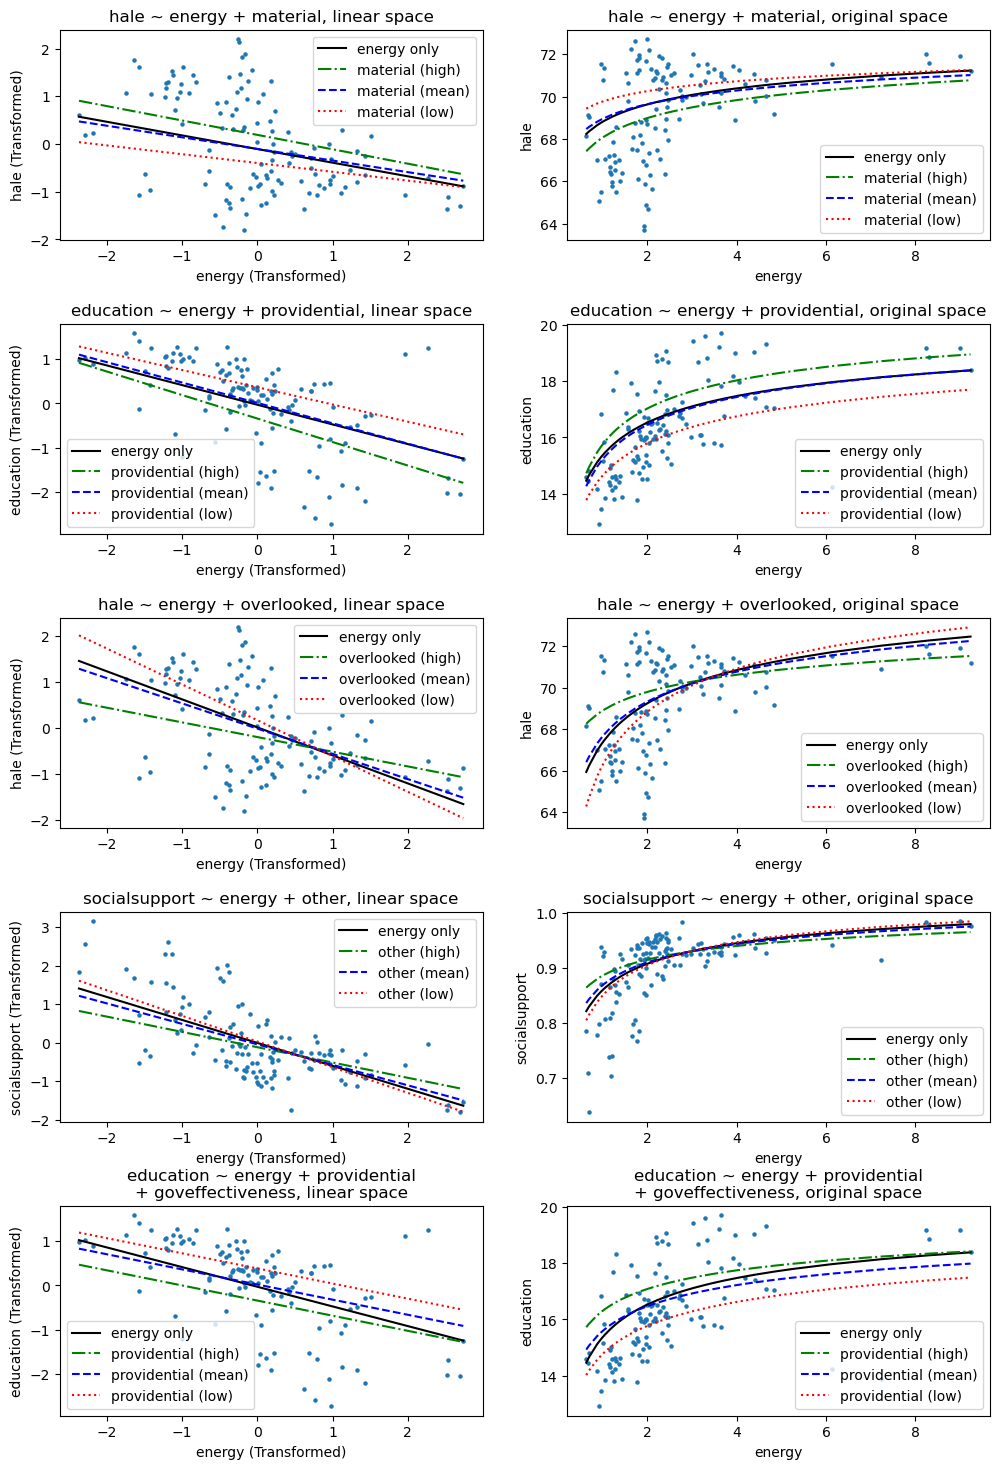

In [125]:
fig, ax = plt.subplots(5, 2, figsize=(12, 18))
plot_predictions_on_ax(ax[0, 0], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_material}, 'hale', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[0, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_material}, 'hale', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_providential}, 'education', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_providential}, 'education', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# predicting labour cost survey data using a regression trained on accounts also works 
plot_predictions_on_ax(ax[2, 0], {'energy_only': selected_bivariate_model_hale_accounts, 'with_provisioning': selected_single_model_overlooked_hale_accounts}, 'hale', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[2, 1], {'energy_only': selected_bivariate_model_hale_accounts, 'with_provisioning': selected_single_model_overlooked_hale_accounts}, 'hale', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
plot_predictions_on_ax(ax[3, 0], {'energy_only': selected_bivariate_model_socialsupport, 'with_provisioning': selected_single_model_socialsupport_other}, 'socialsupport', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[3, 1], {'energy_only': selected_bivariate_model_socialsupport, 'with_provisioning': selected_single_model_socialsupport_other}, 'socialsupport', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plotting multiple provisioning factor regressions also works, setting the value of all extra provisioning factors except one to their means
plot_predictions_on_ax(ax[4, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_multiple_model_education_providential_goveffectiveness}, 'education', ['energy', 'providential', 'goveffectiveness'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[4, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_multiple_model_education_providential_goveffectiveness}, 'education', ['energy', 'providential', 'goveffectiveness'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
fig.subplots_adjust(hspace=0.4)  # Increase hspace for more vertical space